## Loading the Libraries

In [1]:
import pandas as pd
import numpy as np
from boruta                import BorutaPy
import inflection
from sklearn.ensemble       import RandomForestClassifier
import math
from sklearn.model_selection import train_test_split, cross_val_score, KFold,cross_validate,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay, auc
import matplotlib.pyplot as plt
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

## Loading and Separating the Data

In [2]:
mra_tf = pd.read_csv("0_data/MRA_TFs.csv", index_col=0)
print(mra_tf.shape)
metadata = pd.read_csv("0_data/metadata_KIRC_balanced.csv", index_col=0)
print(metadata.shape)
count_data = pd.read_csv("0_data/count_data_KIRC_pc_balanced.csv", index_col=0)
print(count_data.shape)

(356, 8)
(158, 24)
(158, 356)


In [3]:
count_data

,ENSG00000005073,ENSG00000005513,ENSG00000006468,ENSG00000006704,ENSG00000007372,ENSG00000007968,ENSG00000008083,ENSG00000008196,ENSG00000009950,ENSG00000010030,...,ENSG00000244405,ENSG00000250312,ENSG00000254004,ENSG00000256771,ENSG00000257923,ENSG00000261787,ENSG00000267041,ENSG00000274349,ENSG00000275004,ENSG00000276644
TCGA-CZ-5984-01A-11R-1672-07,-2.556032,-1.870141,5.501371,4.458109,-7.079594,1.501606,4.009856,-7.079594,5.707288,3.793081,...,5.128335,2.754877,4.615199,3.358158,7.426527,-4.272239,0.018438,1.334034,0.627765,1.691895
TCGA-B0-4841-01A-01R-1277-07,0.191432,0.811160,2.734747,3.970871,-5.166120,-0.036837,5.259096,-0.411232,7.038146,1.910696,...,4.398030,1.752744,4.642844,2.426337,7.467103,-5.166120,-1.259229,1.309614,-1.465680,4.420720
TCGA-B0-4700-01A-02R-1541-07,2.336602,-1.228655,4.647148,3.631638,0.762933,2.266921,4.467261,-3.484994,2.990739,4.223898,...,4.719577,2.450989,4.117395,2.722291,6.860164,-6.654919,0.876462,0.333765,1.079790,1.999717
TCGA-B0-4690-01A-01R-1277-07,2.302006,-1.231784,5.794010,5.280615,0.454462,2.044848,4.443724,-0.673294,2.843282,2.632515,...,5.223767,2.283773,4.133425,2.965567,7.630318,-4.691216,0.666336,0.533751,-0.001916,1.961271
TCGA-B4-5836-01A-11R-1672-07,-0.467109,-0.565513,2.906211,3.710721,1.686875,0.851645,4.670305,-3.274464,2.104581,2.280125,...,4.504372,2.872154,4.677493,3.477338,7.708694,-6.974903,0.476308,2.010938,-1.302478,2.821136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CJ-4641-01A-02R-1325-07,-0.333976,-1.008880,3.293939,4.231702,-3.671845,1.798474,4.268713,-1.712487,5.276846,4.294580,...,4.854762,2.957511,4.380421,3.721426,7.386672,-6.841770,0.689611,1.546247,1.546247,1.229692
TCGA-CZ-5462-01A-01R-1503-07,-1.461652,-2.988899,1.303016,4.722515,-2.828434,-0.042939,3.994430,-7.076362,1.118395,3.946699,...,4.285034,2.822995,4.446710,3.148845,7.645004,-7.076362,-1.053994,0.940446,-1.584509,0.199762
TCGA-DV-5567-01A-01R-1541-07,-0.025818,-0.095640,3.909567,4.282986,-7.014503,-0.356292,4.499718,5.010983,2.583549,0.261621,...,5.726753,2.835684,5.176865,3.940420,7.332911,-7.014503,1.954164,1.865080,-2.766576,2.758636
TCGA-BP-4993-01A-02R-1420-07,0.504494,1.178979,3.230431,4.687629,-3.926555,-0.226116,4.664299,-6.733910,4.896812,3.267498,...,4.796008,2.647633,4.550914,3.493706,7.212539,-6.733910,0.873420,1.400516,-1.061485,2.985479


In [4]:
X = count_data
print(type(X))
print(X.shape)
y = metadata['ajcc_pathologic_m']
print(type(y))
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
(158, 356)
<class 'pandas.core.series.Series'>
(158,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(110, 356)
(110,)
(48, 356)
(48,)


## Performing the FS with Balanced Dataset

In [8]:
X_train

,ENSG00000005073,ENSG00000005513,ENSG00000006468,ENSG00000006704,ENSG00000007372,ENSG00000007968,ENSG00000008083,ENSG00000008196,ENSG00000009950,ENSG00000010030,...,ENSG00000244405,ENSG00000250312,ENSG00000254004,ENSG00000256771,ENSG00000257923,ENSG00000261787,ENSG00000267041,ENSG00000274349,ENSG00000275004,ENSG00000276644
TCGA-CJ-4881-01A-01R-1305-07,2.605462,-0.910638,2.676360,4.472919,3.523000,1.603323,4.326308,-3.623356,3.313936,2.286203,...,4.677886,2.231858,4.152894,2.655867,6.878591,-6.793281,0.722418,0.674324,1.765139,2.010850
TCGA-B0-4814-01A-01R-1277-07,-0.458794,-0.794843,3.757228,4.759746,-3.025141,0.851848,4.326308,-4.403652,4.977891,3.797001,...,3.633071,2.827089,4.442465,3.463008,7.216109,-3.555655,1.696484,2.282848,-2.638118,2.310593
TCGA-BP-4798-01A-01R-1305-07,1.133521,-1.514551,4.354911,4.029518,2.359118,1.623752,4.747658,-1.827709,1.389991,4.364509,...,5.899592,3.129305,4.177064,3.294060,7.414238,-5.287141,1.436236,1.342216,0.643596,1.199359
TCGA-B2-4099-01A-02R-1188-07,0.124090,-1.566806,2.164998,3.897302,-6.696089,0.850805,3.477588,-4.374161,3.737496,3.928706,...,4.491881,3.053780,4.591046,3.891688,6.497898,-6.696089,0.580035,2.383396,-1.486636,0.721763
TCGA-CJ-4874-01A-01R-1305-07,0.594557,-1.116722,2.974065,3.707707,-6.789147,1.159220,4.103396,-5.204184,3.302289,4.116992,...,4.940899,2.834735,4.735884,3.675399,7.315698,-6.789147,0.105671,2.059476,-0.249988,3.524870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BP-4994-01A-01R-1334-07,2.817369,2.802406,2.111492,4.407285,-4.196341,-0.858472,3.708544,-1.638346,3.995129,2.970240,...,3.845014,3.106425,5.469981,4.317167,7.169799,-5.044338,1.444305,0.778392,2.078749,3.347120
TCGA-CJ-4875-01A-01R-1305-07,0.688312,-1.114007,2.769232,4.936240,-3.012127,1.207921,4.357371,-3.664204,6.717494,3.986848,...,3.697113,2.759662,4.317159,3.244403,7.388655,-4.886596,0.859358,1.863832,0.626473,3.030278
TCGA-B4-5377-01A-01R-1503-07,-1.587017,-0.839204,2.669481,3.902415,-4.993009,0.392422,3.881665,-3.614497,4.733890,2.810476,...,4.414259,3.183912,4.762212,2.873652,7.542121,-7.314937,-0.155066,1.925854,-1.700227,1.670905
TCGA-CZ-5451-01A-01R-1503-07,-1.229231,-1.157081,3.251896,4.777113,-4.929671,0.886246,4.591930,-3.707278,4.841268,3.552801,...,3.841819,2.845116,4.457628,3.354189,7.651294,-6.514633,1.016748,2.020642,-1.088369,2.827441


In [9]:
y_train

TCGA-CJ-4881-01A-01R-1305-07    M0
TCGA-B0-4814-01A-01R-1277-07    M1
TCGA-BP-4798-01A-01R-1305-07    M1
TCGA-B2-4099-01A-02R-1188-07    M0
TCGA-CJ-4874-01A-01R-1305-07    M0
                                ..
TCGA-BP-4994-01A-01R-1334-07    M0
TCGA-CJ-4875-01A-01R-1305-07    M1
TCGA-B4-5377-01A-01R-1503-07    M1
TCGA-CZ-5451-01A-01R-1503-07    M0
TCGA-B0-5697-01A-11R-1541-07    M0
Name: ajcc_pathologic_m, Length: 110, dtype: object

## Boruta Feature Selection

### Evaluating the Classification Without the Feature Selection with a 5-Fold CV on a Random Forest

Accuracy scores: [0.63636364 0.77272727 0.59090909 0.59090909 0.68181818]
Mean Accuracy score: 0.6545454545454545 

ROC AUC scores: [0.78512397 0.9338843  0.68333333 0.64166667 0.775     ]
Mean ROC AUC score: 0.763801652892562 

Confusion Matrix:
[[31 21]
 [17 41]] 



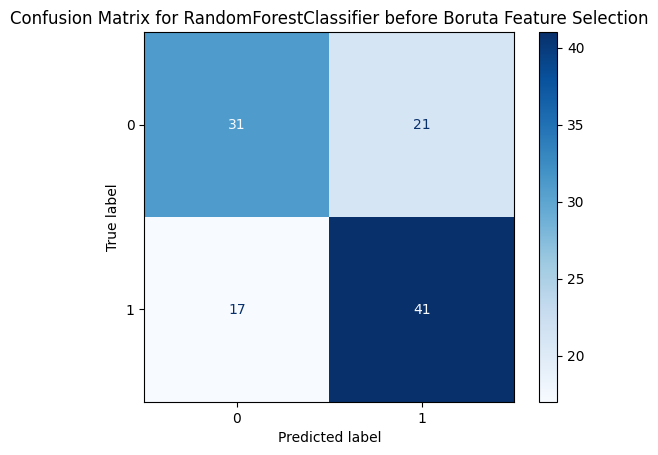

<Figure size 640x480 with 0 Axes>

In [10]:
rf_all_features = RandomForestClassifier(random_state=123, n_estimators=1000, max_depth=5)
# Define the k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Perform cross-validation
scoring=['accuracy', 'roc_auc']
scores_bf_Boruta = cross_validate(rf_all_features, X_train, y_train, cv=kf,scoring=scoring)
y_pred_bf_Boruta = cross_val_predict(rf_all_features, X_train, y_train, cv=kf)

# Print the cross-validation scores and the mean score
print("Accuracy scores:", scores_bf_Boruta['test_accuracy'])
print("Mean Accuracy score:", np.mean(scores_bf_Boruta['test_accuracy']),"\n")

print("ROC AUC scores:", scores_bf_Boruta['test_roc_auc'])
print("Mean ROC AUC score:", np.mean(scores_bf_Boruta['test_roc_auc']),"\n")


# Compute and Print the confusion matrix
cm_bf_boruta = confusion_matrix(y_train, y_pred_bf_Boruta)

print("Confusion Matrix:")
print(cm_bf_boruta,"\n")

disp_bf_boruta = ConfusionMatrixDisplay(confusion_matrix=cm_bf_boruta)
disp_bf_boruta.plot(cmap=plt.cm.Blues)

# Add title and labels
plt.title("Confusion Matrix for RandomForestClassifier before Boruta Feature Selection")
plt.show()

plt.savefig("CM_curve_BF.svg", format="svg",dpi=300)

<Figure size 640x480 with 0 Axes>

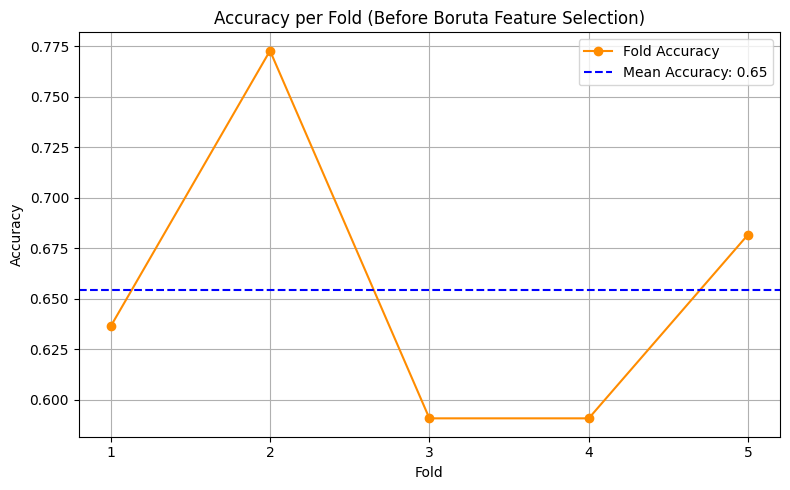

In [23]:
# Plot accuracy over cross-validation folds
folds = range(1, len(scores_bf_Boruta['test_accuracy']) + 1)
accuracies = scores_bf_Boruta['test_accuracy']


plt.figure(figsize=(8, 5))
plt.plot(folds, accuracies, marker='o', linestyle='-', color='darkorange', label='Fold Accuracy')
plt.axhline(np.mean(accuracies), color='blue', linestyle='--', label=f'Mean Accuracy: {np.mean(accuracies):.2f}')
plt.xticks(folds)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold (Before Boruta Feature Selection)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: save the plot
plt.savefig("accuracy_curve_BF.svg", format="svg", dpi=300)

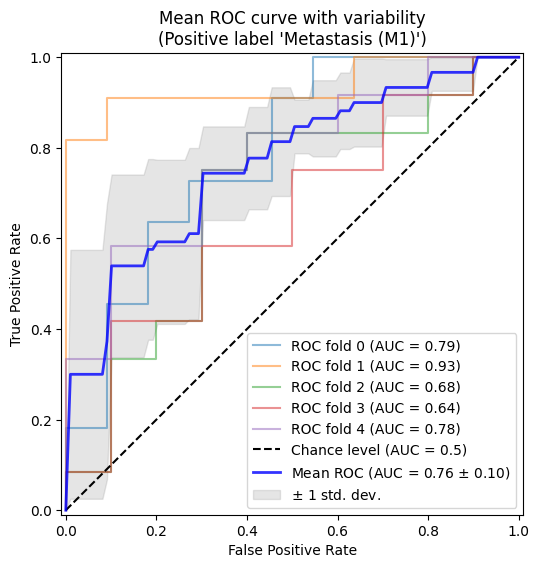

In [12]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()
n_splits = 5
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(kf.split(X_train_array, y_train_array)):
    rf_all_features.fit(X_train_array[train], y_train_array[train])
    viz = RocCurveDisplay.from_estimator(
        rf_all_features,
        X_train_array[test],
        y_train_array[test],
        name=f"ROC fold {fold}",
        alpha=0.5,
        lw=1.5,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'Metastasis (M1)')",
)
ax.legend(loc="lower right")

plt.savefig("ROC_curve_BF.svg", format="svg",dpi=300)

#plt.show()

### Performing the Feature Selection

In [13]:
forest = RandomForestClassifier(random_state=123, n_estimators=1000, max_depth=5)

In [14]:
# define Boruta feature selCheckingection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=123)

# find all relevant features
feat_selector.fit(np.array(X_train), np.array(y_train))

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_train_filtered = feat_selector.transform(np.array(X_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	356
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	356
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	356
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	356
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	356
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	356
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	356
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	322
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	30
Rejected: 	322
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	30
Rejected: 	322
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	30
Rejected: 	322
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	30
Rejected: 	322
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	28
Rejected: 	324
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	28
Rejected: 	324
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	28
Rejected: 	324
Iteration: 	16 / 100
Confirmed: 	6
Tentat

### Selecting the Best Features

In [15]:
selected_bor_features = pd.DataFrame({'Feature':list(X_train.columns),
                                       'Ranking':feat_selector.ranking_}).sort_values(by='Ranking')
selected_bor_features

,Feature,Ranking
312,ENSG00000196646,1
19,ENSG00000050344,1
4,ENSG00000007372,1
316,ENSG00000196867,1
288,ENSG00000185630,1
...,...,...
110,ENSG00000124203,332
258,ENSG00000176692,332
61,ENSG00000105419,334
222,ENSG00000169946,335


In [16]:
new_columns=selected_bor_features[selected_bor_features["Ranking"]==1].index
X_test=X_test.iloc[:,new_columns]
X_test

,ENSG00000196646,ENSG00000050344,ENSG00000007372,ENSG00000196867,ENSG00000185630,ENSG00000007968,ENSG00000101057,ENSG00000111206,ENSG00000137203,ENSG00000274349,ENSG00000215271
TCGA-BP-4340-01A-01R-1289-07,3.876695,2.906266,-3.301887,2.880011,7.168501,-0.028868,0.157545,2.895821,-1.231498,1.816362,5.058887
TCGA-CZ-5465-01A-01R-1503-07,4.233297,5.045664,-2.385422,1.341673,5.159133,0.421933,-0.046112,2.240840,-1.407448,2.420371,3.964111
TCGA-CW-5589-01A-01R-1541-07,3.893826,3.321695,-6.866894,2.800218,7.210506,0.812586,1.843913,2.233769,0.075621,2.006550,4.191775
TCGA-B0-4833-01A-01R-1305-07,3.693704,4.210207,-3.907696,3.276188,5.548042,1.634562,2.381401,2.305651,-0.298887,1.188229,3.734717
TCGA-CZ-5987-01A-11R-1672-07,3.222481,5.638935,-0.582358,0.249915,3.028757,1.834877,3.310389,4.481103,1.002605,0.801557,3.155487
TCGA-B0-4693-01A-01R-1277-07,3.904206,3.402303,-4.234322,2.965351,6.820825,-0.146859,0.990645,2.168264,-0.252469,1.231653,4.264727
TCGA-B0-4688-01A-01R-1277-07,3.059879,5.829754,4.301050,3.351943,4.889382,3.028577,5.924398,8.275482,3.701425,1.075279,4.340980
TCGA-CZ-4856-01A-02R-1426-07,3.592247,4.296459,-3.947773,2.655441,6.203807,1.181510,1.485928,2.347868,-0.609903,1.792195,4.231583
TCGA-CZ-5462-01A-01R-1503-07,3.448180,5.453800,-2.828434,0.530968,5.788018,-0.042939,-0.087677,1.387162,1.585416,0.940446,3.595179
TCGA-BP-5178-01A-01R-1426-07,2.983007,5.518811,-1.804671,0.721053,3.460176,1.030835,3.420828,3.655891,2.964882,0.556517,3.680534


### Evaluating the Classification after the Feature Selection with a 5-Fold CV on a Random Forest

Accuracy scores: [0.8        0.6        0.8        0.88888889 0.88888889]
Mean Accuracy score: 0.7955555555555556 

ROC AUC scores: [0.76190476 0.66666667 1.         0.9        1.        ]
Mean ROC AUC score: 0.8657142857142857 

Confusion Matrix:
[[22  5]
 [ 5 16]] 



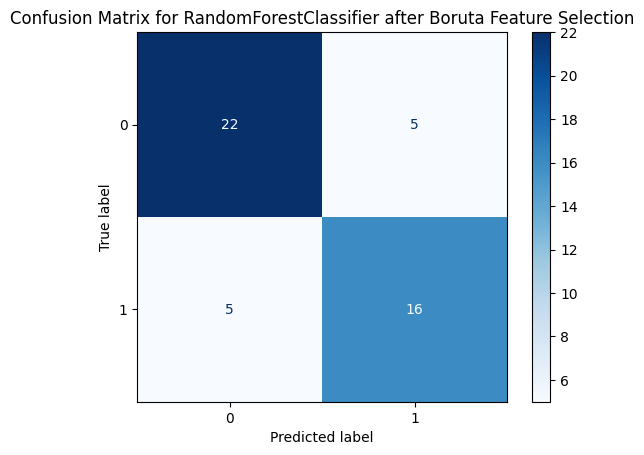

In [17]:
rf_final = RandomForestClassifier(random_state=123, n_estimators=1000, max_depth=5)
# Define the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Perform cross-validation
scoring=['accuracy', 'roc_auc']
scores_af_Boruta = cross_validate(rf_final, X_test, y_test, cv=kf, scoring=scoring)
y_pred_af_Boruta = cross_val_predict(rf_final, X_test, y_test, cv=kf)

# Print the cross-validation scores and the mean score
print("Accuracy scores:", scores_af_Boruta['test_accuracy'])
print("Mean Accuracy score:", np.mean(scores_af_Boruta['test_accuracy']),"\n")

print("ROC AUC scores:", scores_af_Boruta['test_roc_auc'])
print("Mean ROC AUC score:", np.mean(scores_af_Boruta['test_roc_auc']),"\n")

# Compute and Print the confusion matrix
cm_af_boruta = confusion_matrix(y_test, y_pred_af_Boruta)

print("Confusion Matrix:")
print(cm_af_boruta,"\n")

disp_af_boruta = ConfusionMatrixDisplay(confusion_matrix=cm_af_boruta)
disp_af_boruta.plot(cmap=plt.cm.Blues)

# Add title and labels
plt.title("Confusion Matrix for RandomForestClassifier after Boruta Feature Selection")
plt.show
plt.savefig("CM_curve_AF.svg", format="svg",dpi=300)

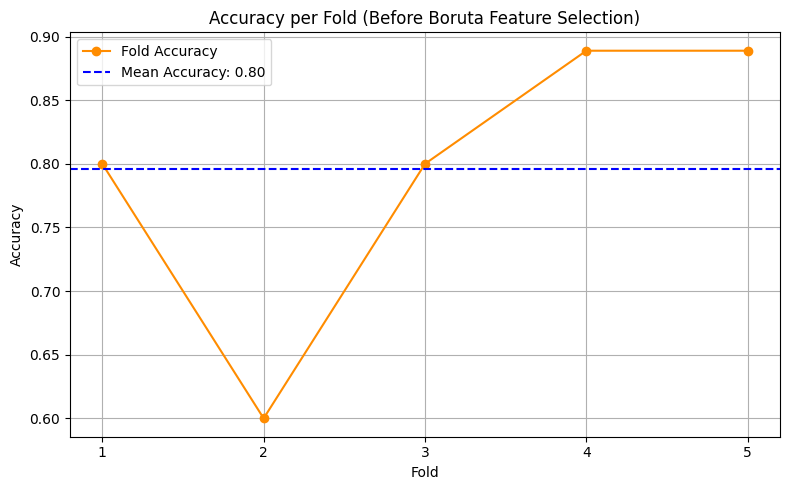

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot accuracy over cross-validation folds
folds = range(1, len(scores_bf_Boruta['test_accuracy']) + 1)
accuracies = scores_af_Boruta['test_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(folds, accuracies, marker='o', linestyle='-', color='darkorange', label='Fold Accuracy')
plt.axhline(np.mean(accuracies), color='blue', linestyle='--', label=f'Mean Accuracy: {np.mean(accuracies):.2f}')
plt.xticks(folds)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold (Before Boruta Feature Selection)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: save the plot
plt.savefig("accuracy_curve_AF.svg", format="svg", dpi=300)


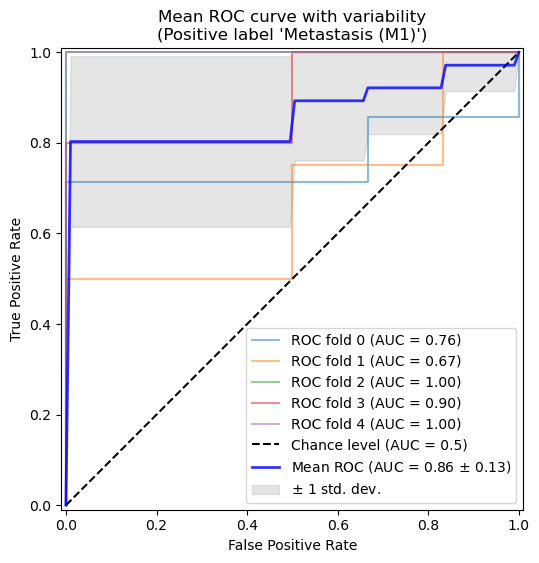

In [20]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X_new_array = X_test.to_numpy()
y_array = y_test.to_numpy()


fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(kf.split(X_new_array, y_array)):
    rf_all_features.fit(X_new_array[train], y_array[train])
    viz = RocCurveDisplay.from_estimator(
        rf_all_features,
        X_new_array[test],
        y_array[test],
        name=f"ROC fold {fold}",
        alpha=0.5,
        lw=1.5,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1)
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'Metastasis (M1)')",
)
ax.legend(loc="lower right")

plt.savefig("ROC_curve_AF.svg", format="svg",dpi=300)

plt.show()

## Saving the Selected Features

In [22]:
# Get column names
colnames = X_test.columns.tolist()

# Write column names to a file
with open('0_data/selected_features_boruta_balanced_2.txt', 'w') as f:
    for colname in colnames:
        f.write(f"{colname}\n")